In [ ]:
# python 3.9.22
!pip install -q numpy pandas seaborn matplotlib scikit-learn pycaret optuna

In [15]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

from pycaret.classification import *
import optuna
import pickle

# Dataset

In [16]:
df = pd.read_csv("dataset/iris.csv")
df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# EDA & Preprocessing

## Dataset Shape

In [17]:
print("Dataset shape:", df.shape)

Dataset shape: (150, 5)


## Dataset Information

In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal-length  150 non-null    float64
 1   sepal-width   150 non-null    float64
 2   petal-length  150 non-null    float64
 3   petal-width   150 non-null    float64
 4   class         150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


## Descriptive Statistics

In [19]:
cat_cols = df.select_dtypes(include='object').columns.tolist()
num_cols = df.select_dtypes(include='number').columns.tolist()

In [20]:
print(df[num_cols].describe().T)

              count      mean       std  min  25%   50%  75%  max
sepal-length  150.0  5.843333  0.828066  4.3  5.1  5.80  6.4  7.9
sepal-width   150.0  3.054000  0.433594  2.0  2.8  3.00  3.3  4.4
petal-length  150.0  3.758667  1.764420  1.0  1.6  4.35  5.1  6.9
petal-width   150.0  1.198667  0.763161  0.1  0.3  1.30  1.8  2.5


## Missing Value

In [21]:
print(df.isnull().sum())

sepal-length    0
sepal-width     0
petal-length    0
petal-width     0
class           0
dtype: int64


## Feature Distribution

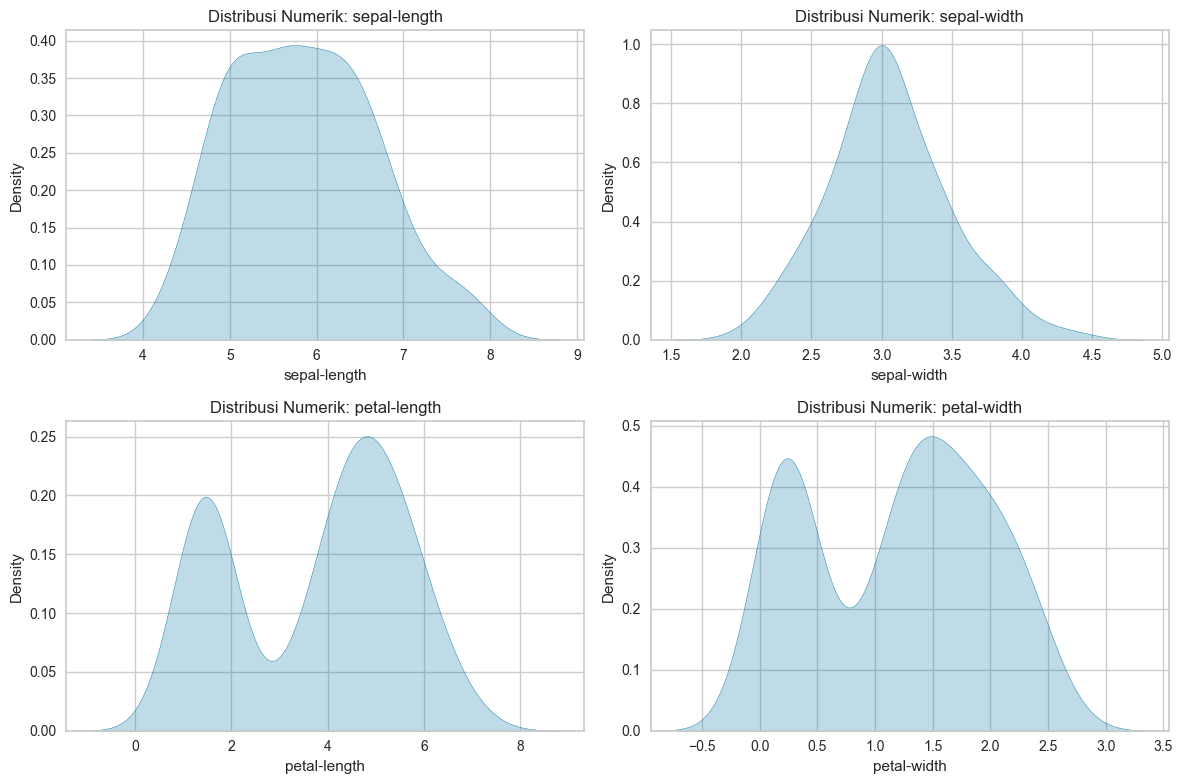

In [22]:
n_cols = len(num_cols)

n_rows = (n_cols + 1) // 2
fig, axes = plt.subplots(n_rows, 2, figsize=(12, 4 * n_rows))
axes = axes.flatten()

for i, col in enumerate(num_cols):
    ax = axes[i]
    sns.kdeplot(df[col], ax=ax, fill=True)
    ax.set_title(f"Distribusi Numerik: {col}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Correlation Matrix

<Axes: >

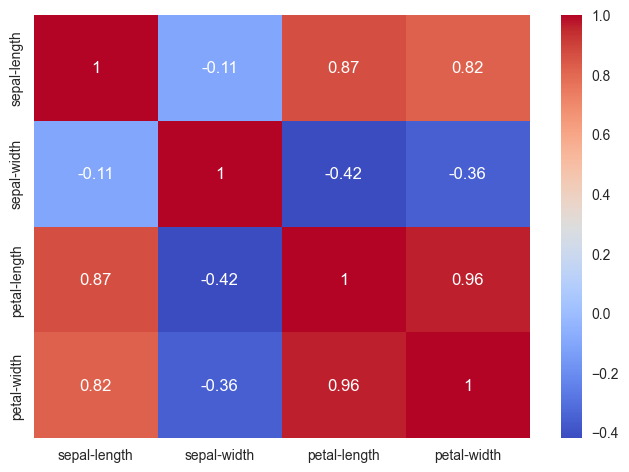

In [23]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="coolwarm")

## Label Encoding

In [24]:
le = LabelEncoder()
df['class'] = le.fit_transform(df['class'])

# Classification Model

## PyCaret Base Modelling

In [25]:
clf_setup = setup(data=df, target='class', session_id=42)
best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,class
2,Target type,Multiclass
3,Original data shape,"(150, 5)"
4,Transformed data shape,"(150, 5)"
5,Transformed train set shape,"(105, 5)"
6,Transformed test set shape,"(45, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.9809,0.0000,0.9809,0.9852,0.9805,0.9711,0.9735,0.0190
nb,Naive Bayes,0.9727,0.9974,0.9727,0.9806,0.9714,0.9588,0.9638,0.0210
lda,Linear Discriminant Analysis,0.9718,0.0000,0.9718,0.9780,0.9712,0.9573,0.9609,0.0200
et,Extra Trees Classifier,0.9718,1.0000,0.9718,0.9780,0.9712,0.9573,0.9609,0.1140
lr,Logistic Regression,0.9618,0.0000,0.9618,0.9705,0.9610,0.9422,0.9470,0.9300
ada,Ada Boost Classifier,0.9618,0.0000,0.9618,0.9705,0.9610,0.9422,0.9470,0.0790
catboost,CatBoost Classifier,0.9618,0.9971,0.9618,0.9705,0.9610,0.9422,0.9470,1.1590
knn,K Neighbors Classifier,0.9527,0.9888,0.9527,0.9595,0.9520,0.9284,0.9322,0.0300
rf,Random Forest Classifier,0.9518,0.9951,0.9518,0.9660,0.9487,0.9270,0.9352,0.1560
gbc,Gradient Boosting Classifier,0.9518,0.0000,0.9518,0.9660,0.9487,0.9270,0.9352,0.1770


## Optuna Hyperparameter Tuning

In [26]:
X = df.drop(columns=["class"])
y = df["class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 300),
        "max_depth": trial.suggest_int("max_depth", 2, 32),
        "min_samples_split": trial.suggest_float("min_samples_split", 0.1, 1.0),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", None]),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy", "log_loss"]),
    }

    model = ExtraTreesClassifier(**params, random_state=42, n_jobs=-1)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    return cross_val_score(model, X, y, cv=cv, scoring="accuracy", n_jobs=-1).mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50)

[I 2025-05-06 09:01:11,814] A new study created in memory with name: no-name-5d87809e-6161-40fa-8f34-73edb3f2984b
[I 2025-05-06 09:01:12,617] Trial 0 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 152, 'max_depth': 14, 'min_samples_split': 0.5287014431850422, 'min_samples_leaf': 3, 'max_features': 'log2', 'criterion': 'log_loss'}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-05-06 09:01:13,355] Trial 1 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 157, 'max_depth': 8, 'min_samples_split': 0.10709085044191928, 'min_samples_leaf': 4, 'max_features': 'log2', 'criterion': 'entropy'}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-05-06 09:01:14,184] Trial 2 finished with value: 0.9533333333333334 and parameters: {'n_estimators': 182, 'max_depth': 6, 'min_samples_split': 0.5878315578487685, 'min_samples_leaf': 4, 'max_features': None, 'criterion': 'gini'}. Best is trial 0 with value: 0.9533333333333334.
[I 2025-05-06 0

## Final Classification Model

In [28]:
best_model = ExtraTreesClassifier(**study.best_trial.params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Akurasi:", accuracy_score(y_test, y_pred))

Akurasi: 1.0


## Save Best Model

In [29]:
with open("best_model/best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("Model berhasil disimpan ke best_model.pkl")

Model berhasil disimpan ke best_model.pkl
